# Building an AI Model for Text Emotion Detection


> Trains Google's BERT over GeoEmotions dataset
([Data Repo](https://github.com/google-research/google-research/tree/master/goemotions), [Paper](https://arxiv.org/pdf/2005.00547.pdf))


## Start GPU Instance

The first thing we'll do is find the GPU and set it as our device to use later on. **Make sure your Runtime type is GPU first**.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

ValueError: ignored

## Get the data

In [ ]:
# Execute linux commands to download data
!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv
!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv
!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv
!wget https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/emotions.txt

--2021-01-31 20:14:48--  https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3519053 (3.4M) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>]   3.36M  --.-KB/s    in 0.04s   

2021-01-31 20:14:48 (87.9 MB/s) - ‘train.tsv’ saved [3519053/3519053]

--2021-01-31 20:14:48--  https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

## Prepare the data

Now, we must collect the data from raw files to pandas dataframes for training

In [ ]:
import pandas as pd

# Load tsv into dataframes
train_df = pd.read_csv("/content/train.tsv", delimiter="\t", header=None, names=['text','emotion_ids','comment_id'])
val_df = pd.read_csv("/content/dev.tsv", delimiter="\t", header=None, names=['text','emotion_ids','comment_id'])
test_df = pd.read_csv("/content/test.tsv", delimiter="\t", header=None, names=['text','emotion_ids','comment_id'])

# Check that number of data points is correct
# From dataset documentation:
#   Size of training dataset: 43,410
#   Size of test dataset: 5,427
#   Size of validation dataset: 5,426
print('Size of training dataset: {:,}\n'.format(train_df.shape[0]))
print('Size of test dataset: {:,}\n'.format(test_df.shape[0]))
print('Size of validation dataset: {:,}\n'.format(val_df.shape[0]))

Size of training dataset: 43,410

Size of test dataset: 5,427

Size of validation dataset: 5,426



In [ ]:
# Display some rows of dataset to check that it looks correct
# Column 1 - text: the comment's text
# Column 2 - emotions_ids: comma separated list of the emotion ids for comment
# Column 3 - comment_id: the id of the comment
train_df.sample(5)

,text,emotion_ids,comment_id
17443,"It’s a [NAME], very fun guns to shoot. Nothing...",1,eeiv61z
32638,I'm just happy I have the Pen to watch and lis...,17,ed0ze2j
23398,Ignorance is the worst thing that can happen t...,"11,22",ees4omc
23666,I started this morning barging seven minutes l...,22,edtqsu3
8881,Mmmm traveling for work often isn't exactly th...,"3,9",eet3ns7


We only need the text and emotion_ids - let's extract those columns

In [ ]:
train_text = train_df.text.values
train_labels = train_df.emotion_ids.values
val_text = val_df.text.values
val_labels = val_df.emotion_ids.values
test_text = test_df.text.values
test_labels = test_df.emotion_ids.values

Now, we need to format the labels from strings to arrays of numbers

In [ ]:
train_labels = [list(map(int, t.split(","))) for t in train_labels]
val_labels = [list(map(int, t.split(","))) for t in val_labels]
test_labels = [list(map(int, t.split(","))) for t in test_labels]

Next, convert the labels to one hot vectors

In [ ]:
# Make function to convert our labels to one-hot vectors of length 28 (we have 28 possible labels)
def to_one_hot(labels):
  one_hot = []
  for row in labels:
    new_row = [0.0]*28
    for l in row:
      new_row[l] = 1.0
    one_hot.append(new_row)
  return one_hot


In [ ]:
train_labels = to_one_hot(train_labels)
val_labels = to_one_hot(val_labels)
test_labels = to_one_hot(test_labels)

Let's tokenize and encode the text as numeric values. We'll use the transformers library to get the tokenizer and the model (later on)

In [ ]:
# Install the transformers library
!pip install transformers

     |████████████████████████████████| 1.8MB 17.5MB/s 
     |████████████████████████████████| 890kB 54.7MB/s 
     |████████████████████████████████| 2.9MB 53.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=dcd057003ccffd43e33484668250ea113278650fc607da994a31379d85a78388
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer

# Load the cased BERT base tokenizer - we'll import the actual model later
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Loading BERT tokenizer...


To see what the tokenizer is doing, let's see its output on one piece of text. In a little bit, we'll use the encode function which will handle this.

In [ ]:
# Print the original sentence.
print(' Original: ', train_text[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))

 Original:  My favourite food is anything I didn't have to cook myself.
Tokenized:  ['My', 'favourite', 'food', 'is', 'anything', 'I', 'didn', "'", 't', 'have', 'to', 'cook', 'myself', '.']
Token IDs:  [1422, 9122, 2094, 1110, 1625, 146, 1238, 112, 189, 1138, 1106, 9834, 1991, 119]


We'll find the longest sequence to determine encoder configs

In [ ]:
# First, there were two weird text examples we found, that we'll remove first
import numpy as np
train_text = np.delete(train_text, 28694)
train_text = np.delete(train_text, 13412)
del train_labels[28694]
del train_labels[13412]

In [ ]:
max_len = 0

# For each text...
for sent in train_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens - needed for BERT
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  99


In [ ]:
max_len = 0

# For each text...
for sent in val_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens - needed for BERT
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  57


Since, 99 is the longest sequence, we'll set max length to 100 in the BERT Tokenizer config for training and 64 for validation. We can now perform the tokenization of our data.

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs in training set.
train_input_ids = []
train_attention_masks = []

# For every sentence...
for sent in train_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentest_labels = test_df.emotion_ids.valuestence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    train_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_text[0])
print('Token IDs:', train_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  My favourite food is anything I didn't have to cook myself.
Token IDs: tensor([ 101, 1422, 9122, 2094, 1110, 1625,  146, 1238,  112,  189, 1138, 1106,
        9834, 1991,  119,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs in validation set.
val_input_ids = []
val_attention_masks = []

# For every sentence...
for sent in val_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentest_labels = test_df.emotion_ids.valuestence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    val_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    val_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', val_text[0])
print('Token IDs:', val_input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Is this in New Orleans?? I really feel like this is New Orleans.
Token IDs: tensor([ 101, 2181, 1142, 1107, 1203, 5705,  136,  136,  146, 1541, 1631, 1176,
        1142, 1110, 1203, 5705,  119,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


Now, we setup the training/validation splits as iterators - this way, data is only pulled into RAM as needed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Put training examples into tensor dataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
# Put validation examples into tensor dataset
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# Define batch size - paper recommends 16
batch_size = 16

# Create data loader iterator for training data - randomized order
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# Create data loader iterator for validation data - sequential since order doesn't matter 
valid_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

## Model Training

We'll need to load the model and put it on the GPU.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with cased vocab.
    num_labels = 28,   # We have 28 emotion classifications
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Now, we'll set different optimizer and training configurations - following the paper.

In [ ]:
# Use AdamW Optimization - more info @ https://towardsdatascience.com/why-adamw-matters-736223f31b5d
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

In [ ]:
# Setting more hyper parameters - continue to follow the paper
from transformers import get_linear_schedule_with_warmup
import math

epochs = 4
warmup_proportion = 0.1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = math.floor(total_steps*warmup_proportion),
                                            num_training_steps = total_steps)

Here, we define a helper function to use in our training loop.

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Now, we can finally train our model! The cell below will train the model - it takes about 1 hour. Google will kill your vm connection if you leave this browser tab idle for too long. So periodically visit this tab during the hour of training.

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value everywhere to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output.logits

        # Calculate loss
        loss = loss_fn(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output.logits

            # Calculate loss
            loss = loss_fn(logits, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,713.    Elapsed: 0:00:12.
  Batch    80  of  2,713.    Elapsed: 0:00:23.
  Batch   120  of  2,713.    Elapsed: 0:00:35.
  Batch   160  of  2,713.    Elapsed: 0:00:47.
  Batch   200  of  2,713.    Elapsed: 0:00:58.
  Batch   240  of  2,713.    Elapsed: 0:01:10.
  Batch   280  of  2,713.    Elapsed: 0:01:22.
  Batch   320  of  2,713.    Elapsed: 0:01:34.
  Batch   360  of  2,713.    Elapsed: 0:01:46.
  Batch   400  of  2,713.    Elapsed: 0:01:57.
  Batch   440  of  2,713.    Elapsed: 0:02:09.
  Batch   480  of  2,713.    Elapsed: 0:02:21.
  Batch   520  of  2,713.    Elapsed: 0:02:33.
  Batch   560  of  2,713.    Elapsed: 0:02:44.
  Batch   600  of  2,713.    Elapsed: 0:02:56.
  Batch   640  of  2,713.    Elapsed: 0:03:08.
  Batch   680  of  2,713.    Elapsed: 0:03:20.
  Batch   720  of  2,713.    Elapsed: 0:03:31.
  Batch   760  of  2,713.    Elapsed: 0:03:43.
  Batch   800  of  2,713.    Elapsed: 0:03:55.
  Batch   840  of

Now, let's save the model to disk on the vm.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './emod_model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./emod_model_save/


('./emod_model_save/tokenizer_config.json',
 './emod_model_save/special_tokens_map.json',
 './emod_model_save/vocab.txt',
 './emod_model_save/added_tokens.json')

We can take a look at how big our model is - about 400 MB

In [ ]:
!ls -l --block-size=M ./emod_model_save/pytorch_model.bin

-rw-r--r-- 1 root root 414M Jan 31 19:21 ./emod_model_save/pytorch_model.bin


To make things easier for yourself, mount your google drive to this vm instance.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


And save a copy of the model in your google drive.

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./emod_model_save/ "./drive/MyDrive/DataColabMM/"

Now that we've backed up our model, let's look at how the training went.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.14,0.09,0:13:17,0:00:22
2,0.08,0.08,0:13:17,0:00:22
3,0.06,0.09,0:13:18,0:00:22
4,0.05,0.09,0:13:18,0:00:22


We can even display our training loss and validation loss graphically. We observe very slight overfitting, but the change in validation loss is very small, so it's probably fine.

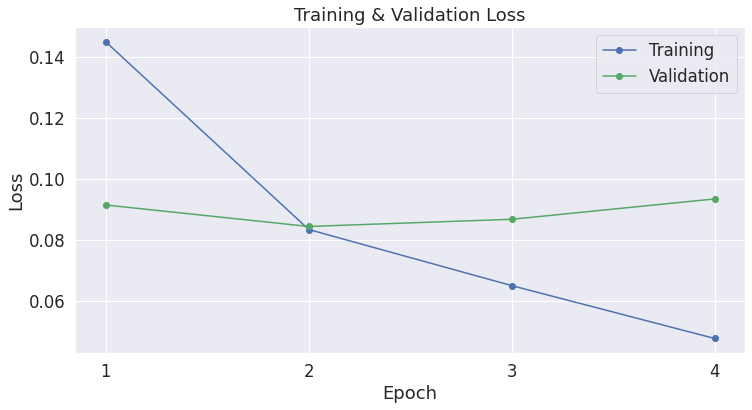

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Model Evaluation

If you already saved the model to google drive and need to reload it, because you closed the browser tab or your runtime expired - rerun the GPU Instance section, then run the two cells below

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.9MB/s 
     |████████████████████████████████| 890kB 39.8MB/s 
     |████████████████████████████████| 2.9MB 33.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1c3446fdcd7ded690f2f1a61a6615d882e5c386b97f6fc7e466f3922cbc143f1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Define the directory where we saved the model (in google drive)
model_dir = "./drive/MyDrive/DataColabMM/emod_model_save"

# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)

# Copy the model to the GPU.
model.to(device)

Now, we can check the model's performance on the test set.

In [ ]:
max_len = 0

# For each text...
for sent in test_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens - needed for BERT
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  72


Since the max test text length is 72, we can set max length to 75. The cell below assumes that you already loaded in the test data in the Prepare the Data section earlier.

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(len(test_text)))

# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 75,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Set the batch size. 
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 5,427



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


We have tokenized and loaded all the necessary test data into an iterator. Now, let's make the test predictions! 

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  preds = torch.sigmoid(logits).cpu().detach().numpy().tolist()
  label_ids = b_labels.cpu().detach().numpy()
  
  # Store predictions and true labels
  predictions.append(preds)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 5,427 test sentences...
    DONE.


We'll reformat the prediction and label arrays:


*   Predictions array will be like [ [idxs of, probabilities, at least, equal to, 0.3], [...], ... ]
*   Labels array will be like [ [idxs of, non-zero, elements], ... ]


In [ ]:
final_preds = []
for b in predictions:
  for prob_lst in b:
    p = []
    for i,val in enumerate(prob_lst):
      if (val>=0.3):
        p.append(i)
    final_preds.append(p)

final_labels = []
for b in true_labels:
  for prob_lst in b:
    idxs = list(np.nonzero(prob_lst)[0])
    final_labels.append(idxs)

Convert these 2-D predictions and labels arrays to Sparse Matrices.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

class_arr = [i for i in range(28)]
mlb = MultiLabelBinarizer(classes=class_arr)
mlb_preds = mlb.fit_transform(final_preds)
mlb_labels = mlb.fit_transform(final_labels)

Finally, calculate the accuracy, micro & macro f1 scores. We get an overall macro f1 of 0.48 (c.f. 0.46 macro f1 reported in the Google paper)

In [ ]:
from sklearn import metrics

accuracy = metrics.accuracy_score(mlb_labels, mlb_preds)
f1_score_micro = metrics.f1_score(mlb_labels, mlb_preds, average='micro')
f1_score_macro = metrics.f1_score(mlb_labels, mlb_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.43817947300534366
F1 Score (Micro) = 0.5895229468599034
F1 Score (Macro) = 0.4833647132944686


## Prediction Analysis

Now, let's create some helpful functions to make a prediction on a given input string.

In [ ]:
import string 

def get_emotions(text):
  # Define the label dictionary
  labels = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral'  
  ]
  label_dict = { i:v for i,v in enumerate(labels)}

  # Let's strip punctuation that could be misleading
  text = ' '.join(word.strip(string.punctuation) for word in text.split())

  # First encode the text with the model's tokenizer
  encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']

  # Put model in evaluation mode
  model.eval()
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_id, token_type_ids=None, 
                      attention_mask=attention_mask)

  # Get probabilities from logits
  logits = outputs[0]
  probs = torch.sigmoid(logits).cpu().detach().numpy().tolist()[0]

  # Get predicted classes
  final_preds = [i for i,val in enumerate(probs) if val>=0.3]
  predicted_labels = [label_dict[c] for c in final_preds]
  
  return predicted_labels
  

Let's look at what it predicts for some pieces of text:

In [ ]:
print(get_emotions("Best thing I’ve seen today. Thanks for the chuckle."))
print(get_emotions("How far is too far?? Killing or rape isnt far enough? Its sick"))
print(get_emotions("I can totally understand this distinction. I used to work at an Indian casino. Have a lot of Native friends and even some 1st cousins that are Native American."))
print(get_emotions("I understand. I think I was just confused by the tone of the post. I wasn’t sure if they were being sarcastic or something"))
print(get_emotions("Seems awfully arbitrary and whimsical, the idea that one can easily discern appreciation from appropriation."))
print(get_emotions("So utterly divorced from reality. The article they linked was misleading and mistranslated"))
print(get_emotions("Holy shit the amount of people in that thread that think it's possible for that to count as consensual is beyond disturbing."))

['admiration', 'gratitude']
['sadness']
['approval']
['confusion']
['annoyance']
['disappointment', 'disapproval']
['annoyance']


Now, let's analyze the model's confidence in its predictions:

In [ ]:
import string 
import matplotlib.pyplot as plt

def get_emotions_plot(text):
  # Define the label dictionary
  labels = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral'  
  ]

  # Let's strip punctuation that could be misleading
  text = ' '.join(word.strip(string.punctuation) for word in text.split())

  # First encode the text with the model's tokenizer
  encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        padding = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
  
  input_id = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']

  # Put model in evaluation mode
  model.eval()
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_id, token_type_ids=None, 
                      attention_mask=attention_mask)

  # Get probabilities from logits
  logits = outputs[0]
  probs = torch.sigmoid(logits).cpu().detach().numpy().tolist()[0]

  # Show prob distribution
  y_pos = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108]
  plt.bar(y_pos, probs)
  plt.xticks(y_pos, labels, rotation='vertical')
  plt.show()


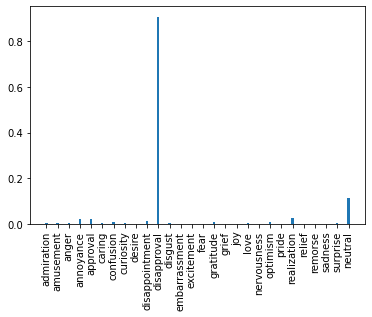

In [ ]:
example1 = "I disagree. Anyone on MySpace in the 2000s could tell you that society can and will migrate when it makes sense for them."

get_emotions_plot(example1)


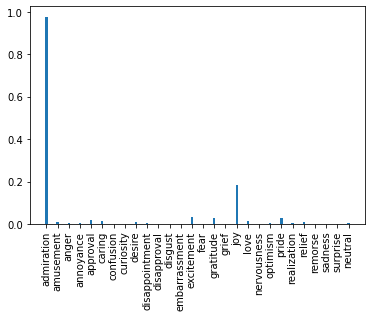

In [ ]:
example2 = "That’s amazing. This is just the kind of news we all need at the moment. Numbers are great but putting it into people context like this makes it even sweeter. I’m so pleased for you and your family!"

get_emotions_plot(example2)


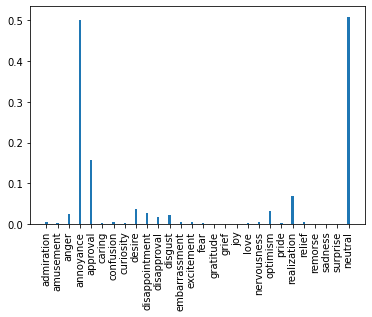

In [ ]:
example3 = "Honestly i feel like some of them are just omega as fuck and need someone to follow. They are easily rallied behind anything and follow the group,"

get_emotions_plot(example3)


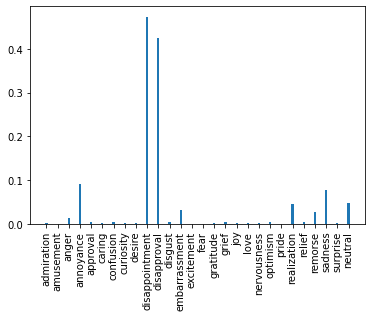

In [ ]:
example4 = "To remember that the white people today are not the whites that performed those acts of hatred, and that the blacks now are not the people that were slaves. Both sides did things that they regret and that were not good. But there is no way to move on and stop mending tensions is both sides do not start to forgive the other."

get_emotions_plot(example4)